This Jupyter notebook runs the optimization program

External packages: pulp, numpy, pandas, networkx, ghudi, matplotlib

In [ ]:
# imports, declare necessary PATH variables

path_to_gurobi = r'C:/gurobi1200/win64' # Set to gurobi path in environment variables
import pulp as pl
import numpy as np
import pandas as pd
from gudhi.representations.preprocessing import BirthPersistenceTransform
from gudhi.representations.vector_methods import PersistenceImage
import re
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [106]:
%run functions_for_analysis.ipynb

Note: the upper and lower bounds are given as percentages of the total number of papers in the corpus (97601)

In [82]:
upper_list =  np.array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.00075, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 1]) * 97601
lower_list = np.array([1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05]) * 97601
df_dx_, fs_d1, fs_d2 = fd_gridSearch('Data/data_for_demonstration/', upper_list, lower_list)

In [99]:
# Collect the magnitude of the gradient vectors and the feature counts at each node into lists, to be passed to the linear program

mag_grad = []
feature_counts_D1 = []
feature_counts_D2 = []
for i in range(len(upper_list)):
    for j in range(1,len(lower_list)):
        mag_grad.append(np.linalg.norm(df_dx_[(i,j)]))
        feature_counts_D1.append(fs_d1[(i,j)])
        feature_counts_D2.append(fs_d2[(i,j)])

We can find the optimal threshold for a given hyperparameterization

In [100]:
optimal_threshold(mag_grad, features_d1=feature_counts_D1, features_d2=feature_counts_D2, delta_ratio_d1=75, delta_ratio_d2=50, n=8*16, quantile=True,solver_path=path_to_gurobi)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads



Academic license 2379170 - for non-commercial use only - registered to as___@macalester.edu
Optimize a model with 3 rows, 128 columns and 375 nonzeros
Model fingerprint: 0x7a84d70b
Variable types: 0 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 5e+00]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-01, 2e+00]
Presolve removed 3 rows and 128 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 54042.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.404279990252e+04, best bound 5.404279990252e+04, gap 0.0000%
Gurobi status= 2


/home/aschr/PythonProjects/TDASummerResearch/oat_env/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


'Chi_63'

In [102]:
# Obtain the optimal selections over a range of hyperparameterizations

optimal_netwx_all = []
for delta1 in range(1,100,10):
    for delta2 in range(1,100,10):
        optimal_netwx_all.append(optimal_threshold(mag_grad, features_d1=feature_counts_D1, features_d2=feature_counts_D2, delta_ratio_d1=delta1, delta_ratio_d2=delta2, n=8*16, quantile=True))

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2379170 - for non-commercial use only - registered to as___@macalester.edu
Optimize a model with 3 rows, 128 columns and 375 nonzeros
Model fingerprint: 0x2ecd6ce0
Variable types: 0 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 5e+00]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-02, 1e+00]
Found heuristic solution: objective 119040.39629
Presolve removed 3 rows and 128 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)



Solution count 2: 18882.2 119040 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.888218640619e+04, best bound 1.888218640619e+04, gap 0.0000%
Gurobi status= 2
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Academic license 2379170 - for non-commercial use only - registered to as___@macalester.edu
Optimize a model with 3 rows, 128 columns and 375 nonzeros
Model fingerprint: 0x1a1f6c4b
Variable types: 0 continuous, 128 integer (0 binary)
Coefficient statistics:
  Matrix range     [3e-04, 5e+00]
  Objective range  [2e+04, 3e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-04, 1e+00]
Found heuristic solution: objective 92071.277594
Presolve removed 3 rows and 128 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds 

We can also visualize the gradient and (normalized) feature count at each network as heat maps.

The optimal selections over the range of valid hyperparameterizations are also plotted as black 'x' markers. Note that as the constraint is increased, the markers generally converge toward the peak of the feature distribution

In [107]:
optimal_indices = []
for dv in optimal_netwx_all:
    if dv != None:
        optimal_indices.append(get_indices(dv, upper_list, lower_list))

/tmp/ipykernel_16126/1981831145.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i,j].set_xticklabels(np.round(lower_list,1))


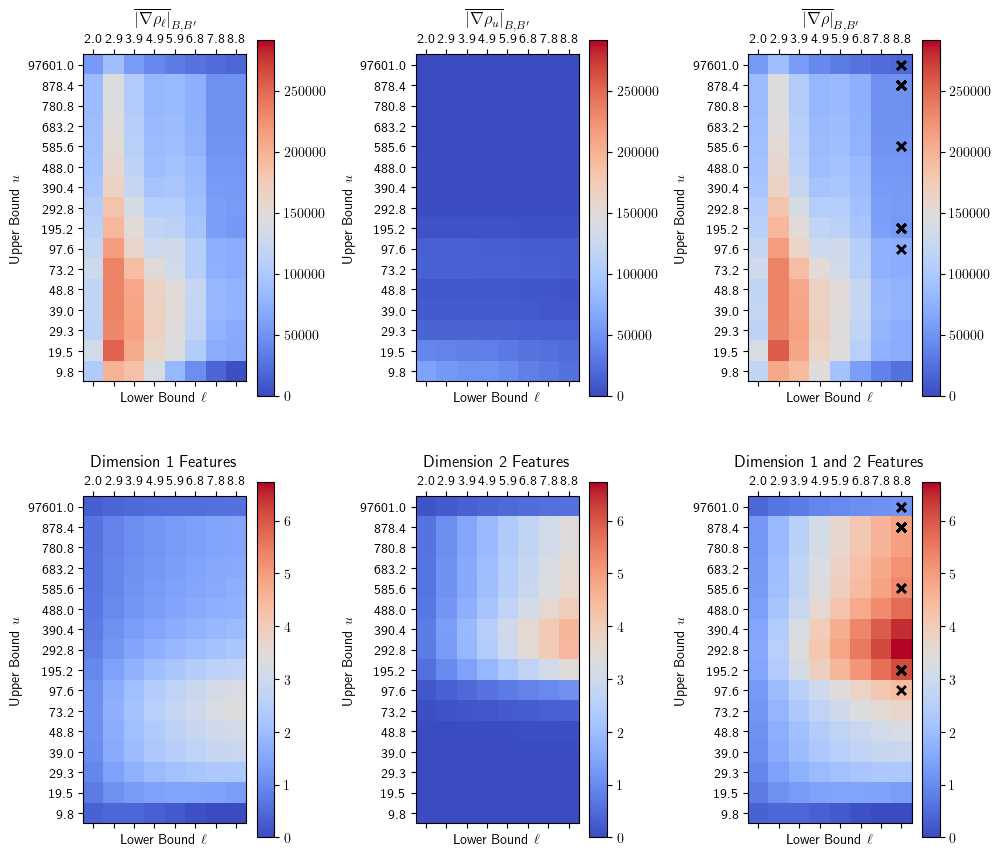

In [111]:
df_du = np.zeros((len(upper_list),len(lower_list)))
df_dl = np.zeros((len(upper_list),len(lower_list)))
df_dx_matrix = np.zeros((len(upper_list),len(lower_list)))
feature_D1_matrix = np.zeros((len(upper_list),len(lower_list)))
feature_D2_matrix = np.zeros((len(upper_list),len(lower_list)))

n = 0
for i in range(len(upper_list)):
    for j in range(1,len(lower_list)):
        grad_entry = df_dx_[(i,j)]

        df_dl[i,j] = grad_entry[0]
        df_du[i,j] = grad_entry[1]
        
        feature_D1_matrix[i,j] = fs_d1[(i,j)]
        feature_D2_matrix[i,j] = fs_d2[(i,j)]

        df_dx_matrix[i,j] = np.linalg.norm(df_dx_[(i,j)])

        n += 1

    

fig,ax = plt.subplots(nrows = 2, ncols = 3, figsize = (10,12))

dmin = min(df_dl.min(), df_du.min())
dmax = (df_du + df_dl).max()
dnorm = colors.Normalize(dmin,dmax)
fmin = min(feature_D1_matrix.min(),feature_D2_matrix.min())
fmax = (feature_D2_matrix + feature_D1_matrix).max()
fnorm = colors.Normalize(fmin,fmax)

d1=ax[0,0].matshow(df_dl[::-1,1:], norm = dnorm, cmap = "coolwarm")
d2=ax[0,1].matshow(df_du[::-1,1:], norm = dnorm, cmap = "coolwarm")
d3=ax[0,2].matshow(df_dx_matrix[::-1,1:], norm = dnorm, cmap = "coolwarm")
f1=ax[1,0].matshow(feature_D1_matrix[::-1,1:], norm = fnorm, cmap = "coolwarm")
f2=ax[1,1].matshow(feature_D2_matrix[::-1,1:], norm=fnorm, cmap = "coolwarm")
f3=ax[1,2].matshow(feature_D1_matrix[::-1,1:] + feature_D2_matrix[::-1,1:], norm=fnorm, cmap = "coolwarm")

fig.colorbar(d1, ax = ax[0,0],shrink=0.5)
fig.colorbar(d2, ax = ax[0,1],shrink=0.5)
fig.colorbar(d3, ax = ax[0,2],shrink=0.5)
fig.colorbar(f1, ax = ax[1,0],shrink=0.5)
fig.colorbar(f2, ax = ax[1,1],shrink=0.5)
fig.colorbar(f3, ax = ax[1,2],shrink=0.5)

for index in optimal_indices:
    ax[0,2].scatter(index[1]-1,15-index[0],color='black', marker='x')
    ax[1,2].scatter(index[1]-1,15-index[0],color='black', marker='x')

for i in range(2):
    for j in range(3):
        ax[i,j].set_xticklabels(np.round(lower_list,1))
        ax[i,j].set_yticks(np.arange(0,16))
        ax[i,j].set_yticklabels(np.round(upper_list[::-1],1))
        ax[i,j].set_xlabel(r'Lower Bound $\ell$')
        ax[i,j].set_ylabel(r'Upper Bound $u$')

ax[0,0].set_title(r"$\overline{|\nabla \rho_{\ell}|}_{B,B'}$")
ax[0,1].set_title(r"$\overline{|\nabla \rho_{u}|}_{B,B'}$")
ax[0,2].set_title(r"$\overline{|\nabla \rho|}_{B,B'}$")
ax[1,0].set_title(r'Dimension 1 Features')
ax[1,1].set_title(r'Dimension 2 Features')
ax[1,2].set_title(r'Dimension 1 and 2 Features')

fig.tight_layout(w_pad=2, h_pad=-20)